<a href="https://colab.research.google.com/github/mohsina-bilal/Movie-Recommendations/blob/main/Copy_of_movie_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Recommendation System

Movie Recommendation Sytem using item-based collaborative filtering on the 25 million movielens dataset.

# **Importing Libraries required**

In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
np.random.seed(123)
import seaborn as sns

!pip install pytorch-lightning
import pytorch_lightning as pl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.4 MB/s eta 0:00:00


In [ ]:
# Adding movies dataset
movies_meta = pd.read_csv('movies.csv')
movies_meta.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
#Adding ratings dataset
ratings = pd.read_csv('ratings.csv', 
                      parse_dates=['timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [ ]:
ratings.size

23859028

# **Data Visualization**

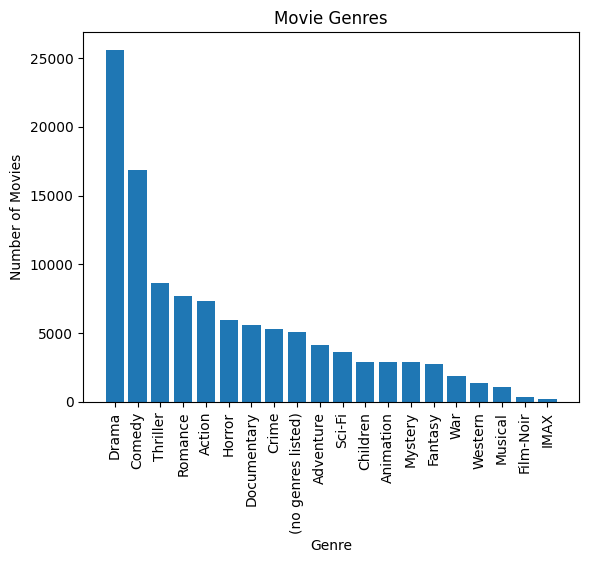

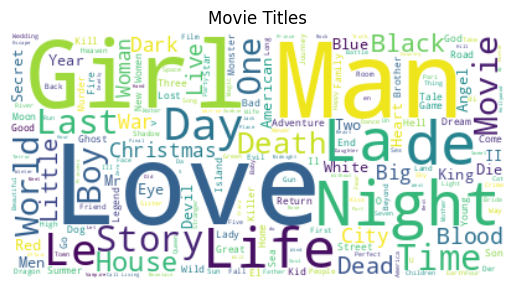

In [ ]:
import matplotlib.pyplot as plt

# create a bar graph of movie genres
genres = movies_meta['genres'].str.split('|', expand=True).stack().value_counts()
plt.bar(genres.index, genres.values)
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Movie Genres')
plt.show()

# create a word cloud of movie titles
from wordcloud import WordCloud

# join all movie titles into a single string
titles = ' '.join(movies_meta['title'].tolist())

# generate word cloud
wordcloud = WordCloud(background_color='white').generate(titles)

# display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Movie Titles')
plt.show()

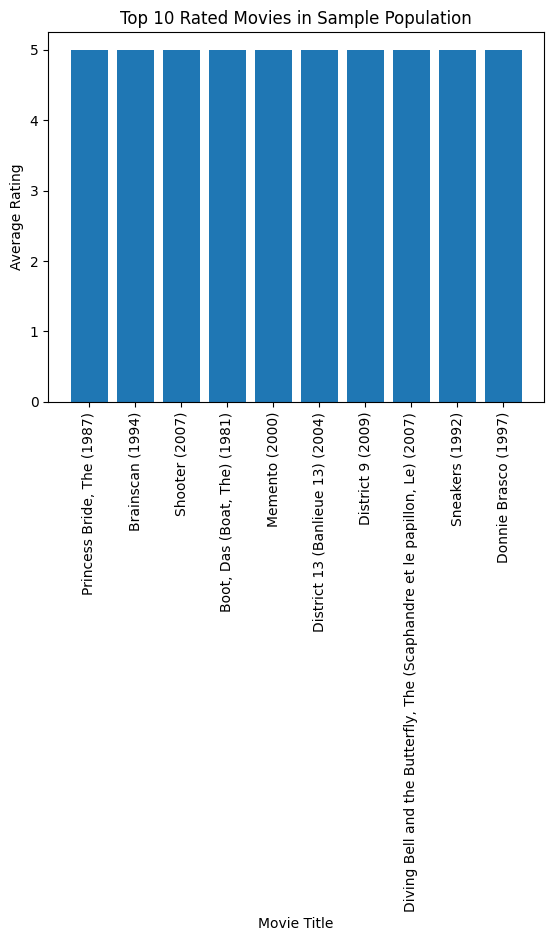

In [ ]:
# merge ratings and movies dataset
merged_data = pd.merge(ratings, movies_meta, on='movieId')

# get a random sample of the merged dataset
sample = merged_data.sample(n=1000)

# create a bar graph of the top 10 rated movies in the sample
top_10_rated_movies = sample.groupby(['title'])['rating'].mean().sort_values(ascending=False).head(10)
plt.bar(top_10_rated_movies.index, top_10_rated_movies.values)
plt.xticks(rotation=90)
plt.xlabel('Movie Title')
plt.ylabel('Average Rating')
plt.title('Top 10 Rated Movies in Sample Population')
plt.show()


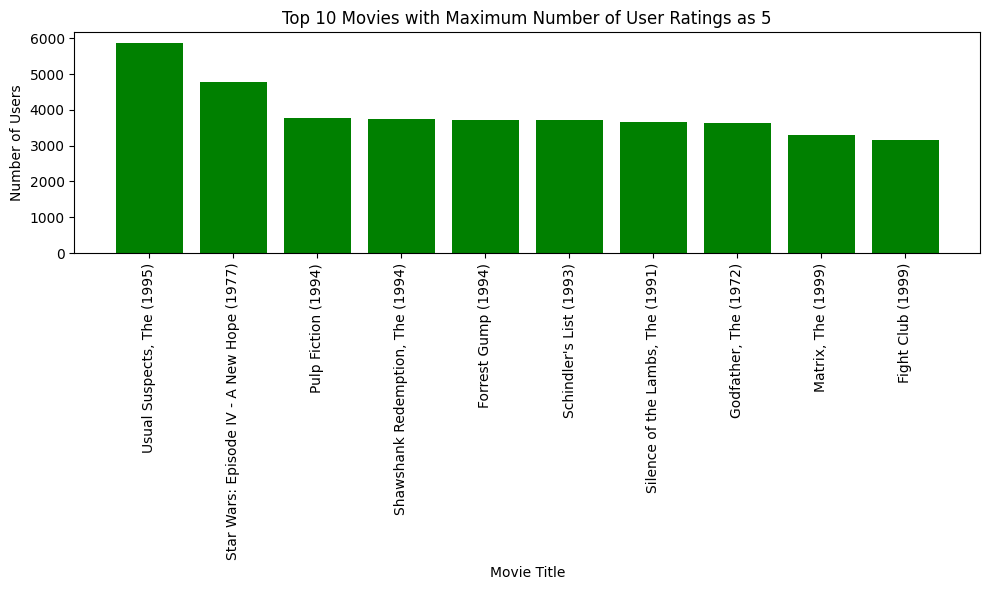

In [ ]:
# Merge the movies and ratings dataframes using the movieid as the common column
merged_df = pd.merge(movies_meta, ratings, on='movieId')

# Filter the merged dataframe to only include movies with a rating of 5
filtered_df = merged_df[merged_df['rating'] == 5]

# Group the filtered dataframe by the movieid and count the number of unique userids for each movie
grouped_df = filtered_df.groupby('movieId')['userId'].nunique()

# Get the top 10 movies with the highest number of users
top_10_movies = grouped_df.nlargest(10)

# Get the titles and number of users for the top 10 movies
result = movies_meta[movies_meta['movieId'].isin(top_10_movies.index)][['title', 'genres']]
result['num_users'] = top_10_movies.values

# Sort the result dataframe by the number of users in descending order
result = result.sort_values('num_users', ascending=False)

# Plot the graph
plt.figure(figsize=(10, 6))
plt.bar(result['title'], result['num_users'], color='green')
plt.xticks(rotation=90)
plt.xlabel('Movie Title')
plt.ylabel('Number of Users')
plt.title('Top 10 Movies with Maximum Number of User Ratings as 5')
plt.tight_layout()
plt.show()


In [ ]:
merged_data = pd.merge(ratings, movies_meta, on='movieId')

# filter movies with rating 5
rating_5_movies = merged_data[merged_data['rating'] == 5]

# count number of movies with rating 5
count = rating_5_movies.shape[0]

print("Number of movies with rating 5: ", count)

Number of movies with rating 5:  858424


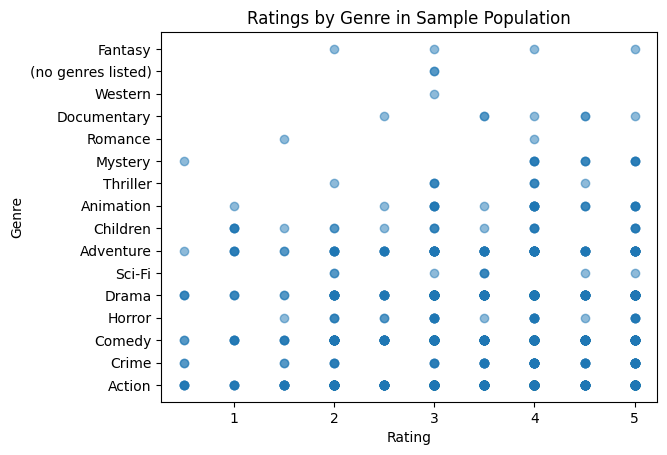

In [ ]:
# create a scatter plot of ratings by genre
genres = movies_meta['genres'].str.split('|', expand=True)
movies_meta['primary_genre'] = genres[0]
sample_with_genre = pd.merge(sample, movies_meta[['movieId', 'primary_genre']], on='movieId')

plt.scatter(sample_with_genre['rating'], sample_with_genre['primary_genre'], alpha=0.5)
plt.xlabel('Rating')
plt.ylabel('Genre')
plt.title('Ratings by Genre in Sample Population')
plt.show()


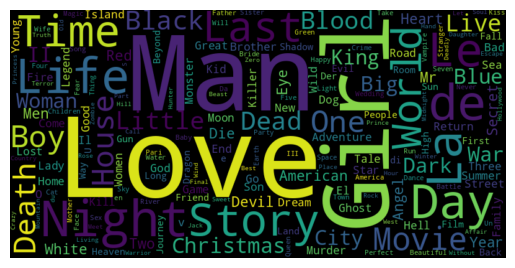

In [ ]:
from wordcloud import WordCloud

# Concatenate all movie titles into a single string
all_titles = " ".join(movies_meta["title"])

# Create a word cloud of the movie titles
wordcloud = WordCloud(width=800, height=400).generate(all_titles)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

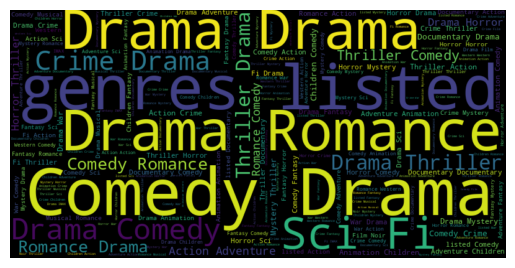

In [ ]:
# Concatenate all movie titles into a single string
all_genres = " ".join(movies_meta["genres"])

# Create a word cloud of the movie titles
wordcloud = WordCloud(width=800, height=400).generate(all_genres)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# **Train and Test Data**



In [ ]:
ratings['timestamp'] = ratings['timestamp']
ratings['rank_latest'] = ratings.groupby(['userId'])['timestamp'] \
                                .rank(method='first', ascending=False)

# Splitting the data into training and testing data where rank either equal or not equal to 1
train_ratings = ratings[ratings['rank_latest'] != 1]
test_ratings = ratings[ratings['rank_latest'] == 1]

# drop columns that we no longer need which is timestamp since splitting is over
train_ratings = train_ratings[['userId', 'movieId', 'rating']]
test_ratings = test_ratings[['userId', 'movieId', 'rating']]

train_ratings.loc[:, 'rating'] = 1

train_ratings.sample(5)

<ipython-input-27-967584c2de7a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ratings.loc[:, 'rating'] = 1
<ipython-input-27-967584c2de7a>:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train_ratings.loc[:, 'rating'] = 1


,userId,movieId,rating
2662303,17712,81132,1
522215,3593,45186,1
516327,3542,246,1
1497845,10009,805,1
278622,1945,134393,1


In [ ]:
#Generating random nehative values (0) for each positive interaction (1) on the ratio of 4:1

# Get a list of all movie IDs
all_movieIds = ratings['movieId'].unique()

# Placeholders that will hold the training data
users, items, labels = [], [], []

# This is the set of items that each user has interaction with
user_item_set = set(zip(train_ratings['userId'], train_ratings['movieId']))

# 4:1 ratio of negative to positive samples
num_negatives = 4

for (u, i) in tqdm(user_item_set):
    users.append(u)
    items.append(i)
    labels.append(1) # items that the user has interacted with are positive
    for _ in range(num_negatives):
        # randomly select an item
        negative_item = np.random.choice(all_movieIds) 
        # check that the user has not interacted with this item
        while (u, negative_item) in user_item_set:
            negative_item = np.random.choice(all_movieIds)
        users.append(u)
        items.append(negative_item)
        labels.append(0) # items not interacted with are negative

  0%|          | 0/3285447 [00:00<?, ?it/s]

# Creating a class to generate tensors of user and item entires 

In [ ]:
class MovieLensTrainDataset(Dataset):
    """MovieLens PyTorch Dataset for Training
    
    Args:
        ratings (pd.DataFrame): Dataframe containing the movie ratings
        all_movieIds (list): List containing all movieIds
    
    """

    def __init__(self, ratings, all_movieIds):
        self.users, self.items, self.labels = self.get_dataset(ratings, all_movieIds)

    def __len__(self):
        return len(self.users)
  
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

    def get_dataset(self, ratings, all_movieIds):
        users, items, labels = [], [], []
        user_item_set = set(zip(ratings['userId'], ratings['movieId']))

        num_negatives = 4
        for u, i in user_item_set:
            users.append(u)
            items.append(i)
            labels.append(1)
            for _ in range(num_negatives):
                negative_item = np.random.choice(all_movieIds)
                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_movieIds)
                users.append(u)
                items.append(negative_item)
                labels.append(0)

        return torch.tensor(users),torch.tensor(items),torch.tensor(labels)

# Creating a class to process the pytorch lightning model 

In [ ]:
class NCF(pl.LightningModule):
    """ Neural Collaborative Filtering (NCF)
    
        Args:
            num_users (int): Number of unique users
            num_items (int): Number of unique items
            ratings (pd.DataFrame): Dataframe containing the movie ratings for training
            all_movieIds (list): List containing all movieIds (train + test)
    """ 
    
    def __init__(self, num_users, num_items, ratings, all_movieIds):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.ratings = ratings
        self.all_movieIds = all_movieIds
        
    def forward(self, user_input, item_input):
        
        # Pass through embedding layers
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        # Concat the two embedding layers
        vector = torch.cat([user_embedded, item_embedded], dim=-1)

        # Pass through dense layer
        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))

        # Output layer
        pred = nn.Sigmoid()(self.output(vector))

        return pred
    
    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return  DataLoader(MovieLensTrainDataset (self.ratings,self.all_movieIds), batch_size=512, num_workers=4)


In [ ]:
num_users = (ratings['userId'].max()+1).astype(int)
num_items = (ratings['movieId'].max()+1).astype(int)

all_movieIds = ratings['movieId'].unique()

model = NCF(num_users, num_items, train_ratings, all_movieIds)

In [ ]:
# Training our NCF model for 5 epochs using the GPU. 
#model = model.to('cuda')
trainer = pl.Trainer(max_epochs= 5, logger=False)
#gpus=1, reload_dataloaders_every_epoch=True, progress_bar_refresh_rate=50,checkpoint_callback=False
trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 175 K 
1 | item_embedding | Embedding | 1.7 M 
2 | fc1            | Linear    | 1.1 K 
3 | fc2            | Linear    | 2.1 K 
4 | output         | Linear    | 33    
----------

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
# User-item pairs for testing
test_user_item_set = set(zip(test_ratings['userId'], test_ratings['movieId']))

# Dict of all items that are interacted with by each user
user_interacted_items = ratings.groupby('userId')['movieId'].apply(list).to_dict()

hits = []
for (u,i) in tqdm(test_user_item_set):
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_movieIds) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]
    
    predicted_labels = np.squeeze(model(torch.tensor([u]*100), 
                                        torch.tensor(test_items)).detach().numpy())
    
    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    
    if i in top10_items:
        hits.append(1)
    else:
        hits.append(0)
        
print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))

  0%|          | 0/21880 [00:00<?, ?it/s]

The Hit Ratio @ 10 is 0.89


In [ ]:
print(hits), len(hits)

[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

(None, 21880)

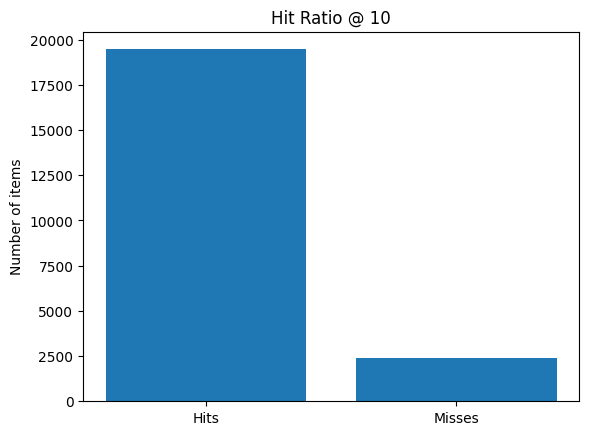

In [ ]:
#graphically understanding the number of hits 
import matplotlib.pyplot as plt

# Count the number of hits and misses
num_hits = sum(hits)
num_misses = len(hits) - num_hits

# Create a bar chart
plt.bar(['Hits', 'Misses'], [num_hits, num_misses])
plt.title('Hit Ratio @ 10')
plt.ylabel('Number of items')
plt.show()


In [ ]:
print(top10_items)

[1704, 6874, 266, 55820, 88140, 45186, 546, 2745, 1212, 3019]


In [ ]:
# Create a dictionary of movie IDs and titles
id2title = {movie_id: movie_title for movie_id, movie_title in zip(movies_meta["movieId"], movies_meta["title"])}

# Iterate through the top 10 items in each hit and print their titles
for (u, i) in tqdm(test_user_item_set):
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_movieIds) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]
    
    predicted_labels = np.squeeze(model(torch.tensor([u]*100), 
                                        torch.tensor(test_items)).detach().numpy())
    
    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    
    if i in top10_items:
        hits.append(1)
        top10_titles = [id2title[item] for item in top10_items]
        print(f"\nUser {u}, recommended movie '{id2title[i]}' was a hit!")
        print("Top 10 recommended movies:")
        for title in top10_titles:
            print(title)
    else:
        hits.append(0)

  0%|          | 0/21880 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Unstoppable (2010)
Amores Perros (Love's a Bitch) (2000)
Sahara (2005)
Alice Through the Looking Glass (2016)
Youth in Revolt (2009)
After Hours (1985)
Sanjuro (Tsubaki Sanjûrô) (1962)
Rebound, The (2009)

User 5266, recommended movie 'Unforgettable (1996)' was a hit!
Top 10 recommended movies:
Wedding Singer, The (1998)
Spaceballs (1987)
Prometheus (2012)
Unforgettable (1996)
Black Beauty (1994)
Waiting for Guffman (1996)
Victor/Victoria (1982)
The Raid: Redemption (2011)
Return to Oz (1985)
Trailer Park Boys: The Movie (2006)

User 4321, recommended movie 'Convent, The (O Convento) (1995)' was a hit!
Top 10 recommended movies:
Basketball Diaries, The (1995)
Fly Away Home (1996)
Popeye (1980)
Fiendish Plot of Dr. Fu Manchu, The (1980)
Wild Bill (1995)
American in Paris, An (1951)
Under the Rainbow (1981)
Mission: Impossible III (2006)
Miracle on 34th Street (1947)
Convent, The (O Convento) (1995)

User 17903, recommended movie 'Patrio